# Enhancing E-commerce Delivery Efficiency through Advanced Analytics and Machine Learning

**Context**

A fictional e-commerce company that sells electronic products wants to discover key insights from its customer database. They want to use some of the most advanced machine learning techniques to study their customers.

\
**Project Objective:**
* Discover key insights from the data
* Analyse delivery on time rate
* Analyse courier performance to recommend the best options.
* Cluster orders to optimise batching/packaging
* Predicts late deliveries based on order/courier/shipping attributes.
* Visualises key logistics metrics in an interactive dashboard.


In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
from scipy.stats import ttest_ind

In [3]:
data = pd.read_csv('Enhanced_Ecommerce_Shipping_Data.csv')

In [4]:
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Courier_ID
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,Courier_4
1,2,F,Flight,4,5,216,2,low,M,59,3088,1,Courier_5
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,Courier_3
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1,Courier_5
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,Courier_5


In [5]:
df = data.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
 12  Courier_ID           10999 non-null  object
dtypes: int64(8), object(5)
memory usage: 1.1+ MB


In [7]:
df.isnull().sum()

,0
ID,0
Warehouse_block,0
Mode_of_Shipment,0
Customer_care_calls,0
Customer_rating,0
Cost_of_the_Product,0
Prior_purchases,0
Product_importance,0
Gender,0
Discount_offered,0


In [8]:
#checking for sum of duplicated rows
df.duplicated().sum()

np.int64(0)

In [9]:
df=df.rename(columns={'Reached.on.Time_Y.N' : 'Reached_on_time'})


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,10999.0,5500.000000,3175.282140,1.0,2750.5,5500.0,8249.5,10999.0
Customer_care_calls,10999.0,4.054459,1.141490,2.0,3.0,4.0,5.0,7.0
Customer_rating,10999.0,2.990545,1.413603,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,10999.0,210.196836,48.063272,96.0,169.0,214.0,251.0,310.0
Prior_purchases,10999.0,3.567597,1.522860,2.0,3.0,3.0,4.0,10.0
Discount_offered,10999.0,13.373216,16.205527,1.0,4.0,7.0,10.0,65.0
Weight_in_gms,10999.0,3634.016729,1635.377251,1001.0,1839.5,4149.0,5050.0,7846.0
Reached_on_time,10999.0,0.596691,0.490584,0.0,0.0,1.0,1.0,1.0


the data seems normally distributed
- although, discount_offered might contain outliers

##EDA

###Univariate Analysis

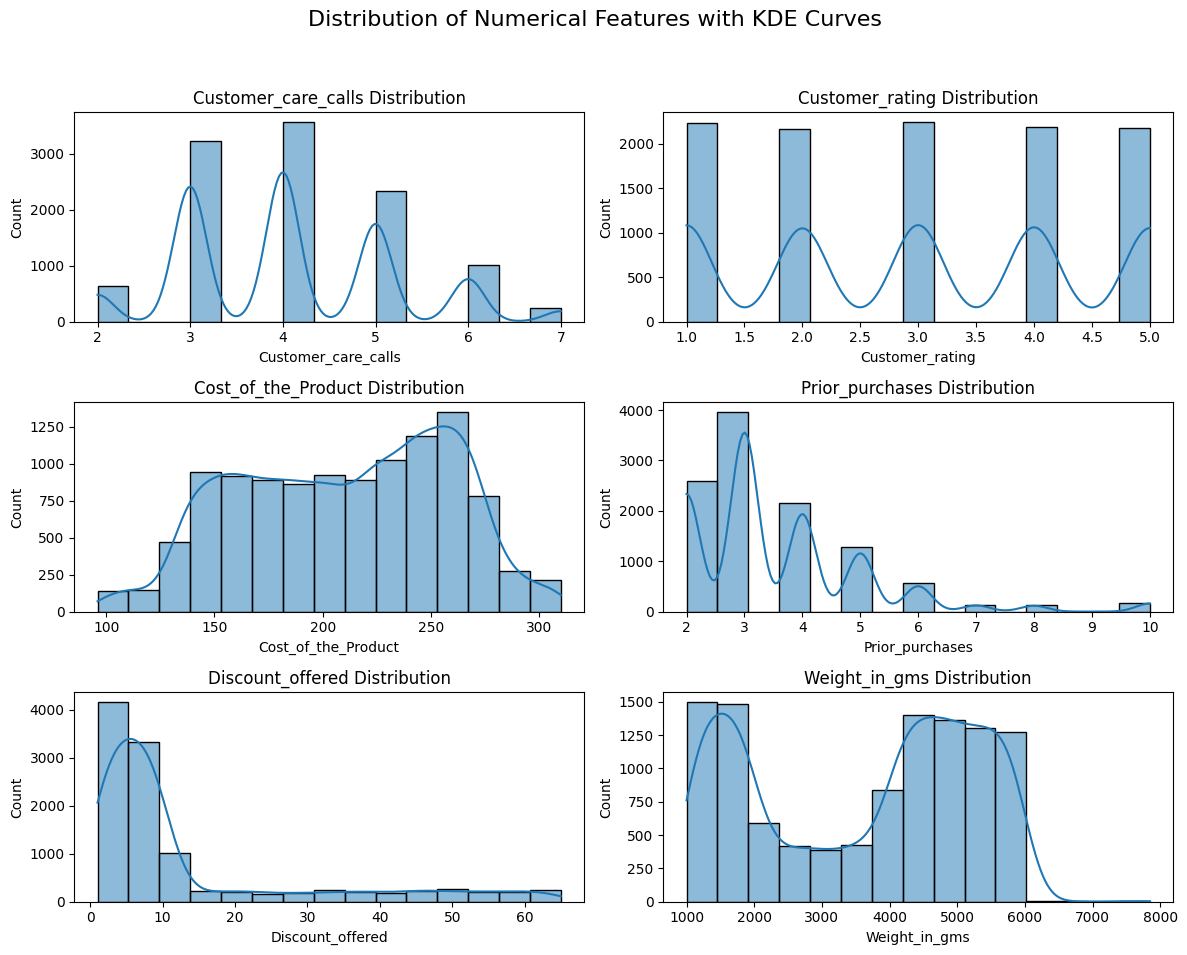

In [107]:
numeric_features = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
                    'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

plt.figure(figsize=(12, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i + 1)
    sns.histplot(data=df, x=feature, bins=15, kde=True)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.suptitle('Distribution of Numerical Features with KDE Curves', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Histogram Analysis: Numerical Variables
1. Customer_care_calls ranges from 2 to 7 calls.

Insight: Most customers make 3 to 4 calls, indicating common service needs or delivery issues.

Action: Couriers associated with higher call volumes may need service reviews.

2. Customer_rating -  All ratings from 1 to 5 are evenly distributed.

Action: May not be very predictive alone. Combine with delay info to spot patterns (e.g., late deliveries → low ratings?).

3. Cost_of_the_Product- (more mid-range products) - most products cost between 150–250 units.

4. Prior_purchases - Right-skewed.

Insight: Most customers have 2–4 prior purchases. Few loyal repeat buyers.


5. Discount_offered - Strong right skew - Majority of orders have low or no discounts.

Action: High discounts could impact courier profitability or urgency — explore if they correlate with delays.

6. Weight_in_gms - Bimodal distribution

Insight: Two main peaks suggest different product categories: lightweight vs. heavy goods.

Action: Crucial for batching/clustering. You shouldn't batch 6kg items with 1kg ones — weight clearly separates shipping needs.

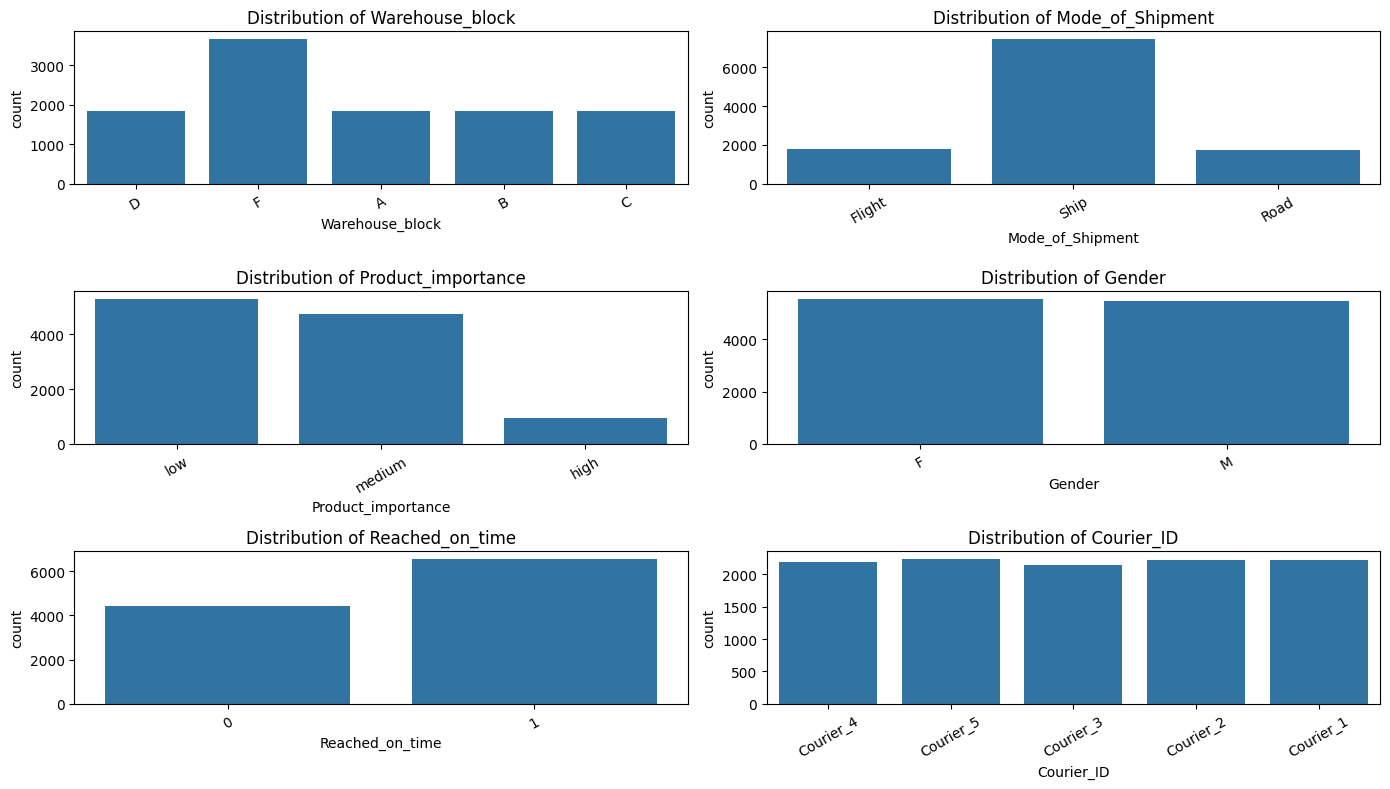

In [12]:
categorical_features = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'Reached_on_time','Courier_ID']

plt.figure(figsize=(14, 8))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

Analysis of Categorical Feature Distributions
1. Warehouse_block
- Block F dominates shipments. Could be a central hub or heavily used node. High volume may cause congestion/delays.

Action: Compare delay rates by warehouse block — F may need load balancing.

2. Mode_of_Shipment
- Vast majority shipped via Ship, with far fewer via Flight or Road.
- Cost-effective but possibly slower. Important to correlate with late deliveries.

Action: Explore whether using Flight or Road improves delivery time for high-priority items.

3. Product_importance
- Mostly low and medium importance; high is rare.
- Might affect prioritization in logistics. High importance products may need special courier handling.

4. Reached_on_time (Y/N) - About 40% late deliveries (0).

5. The other categories have subcategories that are roughly almost equal

### BI-Variate and Multi-Variate Analysis

In [13]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_time,Courier_ID
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,Courier_4
1,2,F,Flight,4,5,216,2,low,M,59,3088,1,Courier_5
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,Courier_3
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1,Courier_5
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,Courier_5


### Product Importance vs Delay

**Hypothesis:**
High Product_importance should be delivered more reliably. But they're rare — is their priority being respected?

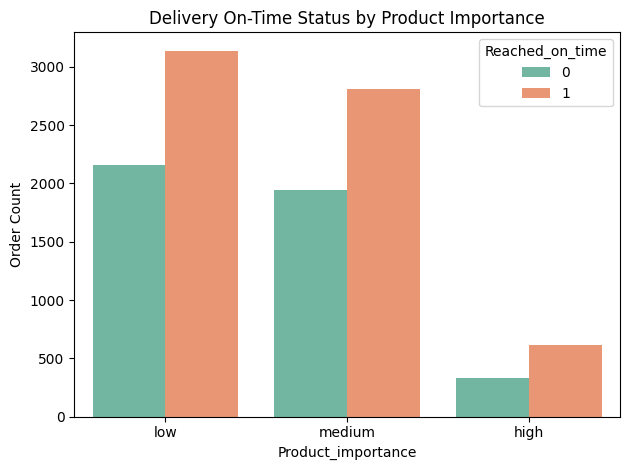

In [14]:
# Countplot with hue
sns.countplot(data=df, x='Product_importance', hue='Reached_on_time', palette='Set2')
plt.title('Delivery On-Time Status by Product Importance')
plt.ylabel('Order Count')
plt.tight_layout()
plt.show()

In [15]:
df.groupby('Product_importance')['Reached_on_time'].value_counts()

Product_importance  Reached_on_time
high                1                   616
                    0                   332
low                 1                  3140
                    0                  2157
medium              1                  2807
                    0                  1947
Name: count, dtype: int64

In [16]:
#Proportion Delivered On Time by Product Importance (0-1, i.e 0%-100%)
df.groupby('Product_importance')['Reached_on_time'].mean()

,Reached_on_time
Product_importance,
high,0.649789
low,0.592788
medium,0.590450


* High-priority products indeed have better on-time performance (65%) compared to Low/Medium (59%).

* This supports the hypothesis that priority influences delivery treatment, even though high-priority products are fewer, they appear to be handled more carefully.

**Actionable Insight:**
Ensure SLAs for high-priority SKUs are upheld or even improved. Monitor if low-importance products are deprioritized too much, especially if delays lead to complaints or churn.

### Mode of Shipment vs Delay
**Hypothesis:**
Shipping by flight or road may be faster than ship. Ship may cause delays due to high volume.

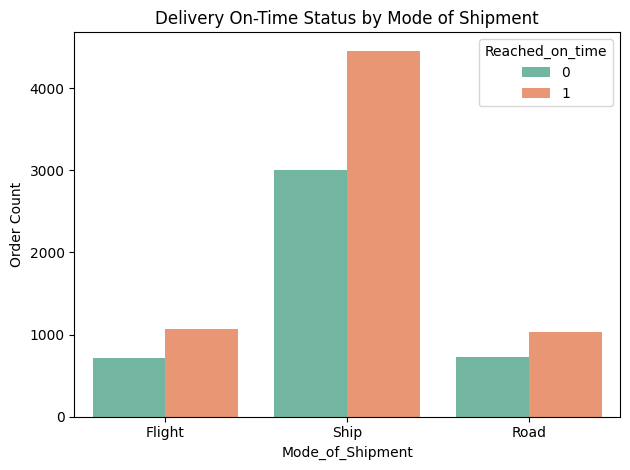

In [17]:
# Shipment method count by delivery status
sns.countplot(data=df, x='Mode_of_Shipment', hue='Reached_on_time', palette='Set2')
plt.title('Delivery On-Time Status by Mode of Shipment')
plt.ylabel('Order Count')
plt.tight_layout()
plt.show()


In [111]:
df['Mode_of_Shipment'].value_counts(normalize=True)

,proportion
Mode_of_Shipment,
Ship,0.678425
Flight,0.161560
Road,0.160015


In [18]:
#Proportion Delivered On Time by Mode_of_Shipment (0-1, i.e 0%-100%)
df.groupby('Mode_of_Shipment')['Reached_on_time'].mean()


,Reached_on_time
Mode_of_Shipment,
Flight,0.601576
Road,0.588068
Ship,0.597561


* ~68% of all shipments are via Ship (7,462 orders). Flight and Road combined handle only about 32%, which confirms Ship is the default mode (likely for cost reasons).

* Although Flight performs slightly better (60.2%), its usage is low.

* Ship, despite the load, maintains comparable on-time performance, which suggests fairly good operational management for high volume.

* Road has the worst performance, even with moderate volume.



**Actionable Recommendations**
Create routing rules

### Are certain product priorities linked to faster shipping methods?

In [19]:
# are certain product priorities linked to faster shipping methods?
pd.crosstab(df['Product_importance'], df['Mode_of_Shipment'], normalize='index') * 100

Mode_of_Shipment,Flight,Road,Ship
Product_importance,,,
high,17.194093,16.666667,66.139241
low,15.820276,16.178969,68.000755
medium,16.323096,15.671014,68.005890


- The majority of high-priority items (66%) still ship via Ship, same as lower-priority items.

- Only 17.2% of high-priority products use Flight, and almost no difference from low/medium products.


it seems like Product priority is not being used effectively to choose faster modes. There is no special handling for high-priority goods in current shipment routing.

### How does on-time delivery rates across combinations look like?

In [20]:
# check delays by product importance + mode.
df.groupby(['Product_importance', 'Mode_of_Shipment'])['Reached_on_time'].mean().unstack()

Mode_of_Shipment,Flight,Road,Ship
Product_importance,,,
high,0.582822,0.651899,0.666667
low,0.599045,0.588098,0.592449
medium,0.608247,0.574497,0.589855


- High-priority products perform best when shipped via Road or Ship, worse with Flight, possibly due to logistics handover complexity.

- Medium & Low importance items experience more delays via Road, and are better with flight (the range is low though)

- Surprisingly, Ship performs better than expected for High importance.

**Conclusion:**
While we assumed Flight would be best for high-importance items, Ship + Road currently perform better for them, possibly due to volume planning or delivery network optimization.



### Do couriers perform differently by product importance or mode?


#### Which couriers are most/least reliable?

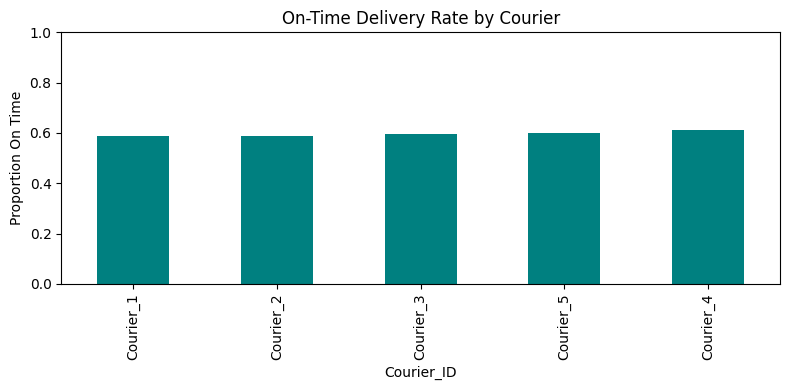

In [21]:
# Courier-wise On-Time Delivery Rate
courier_perf = df.groupby('Courier_ID')['Reached_on_time'].mean().sort_values()

courier_perf.plot(kind='bar', figsize=(8,4), color='teal', title='On-Time Delivery Rate by Courier')
plt.ylabel('Proportion On Time')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


- The spread is small, but Courier_1 underperforms and Courier 4 is the best

#### Do couriers fail more often for High-priority products?

In [22]:
courier_importance = df.groupby(['Courier_ID', 'Product_importance'])['Reached_on_time'].mean().unstack()

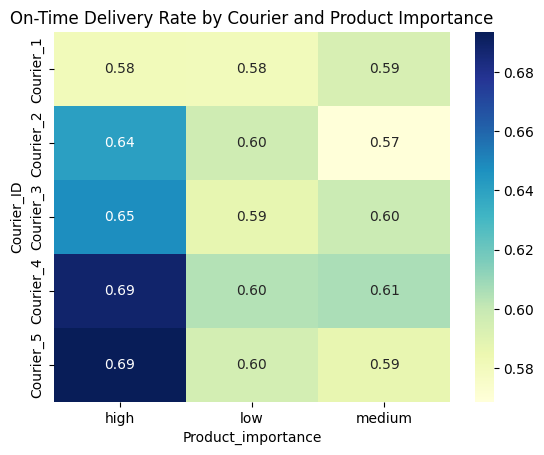

In [23]:
sns.heatmap(courier_importance, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('On-Time Delivery Rate by Courier and Product Importance')
plt.show()

- Courier_1 has the lowest on-time rate for high-priority products (~58%), this is a serious SLA concern.
- Courier_4 and Courier_5 perform best for High importance (~ 69%).


#### Which couriers are better at handling Flight, Ship, or Road?

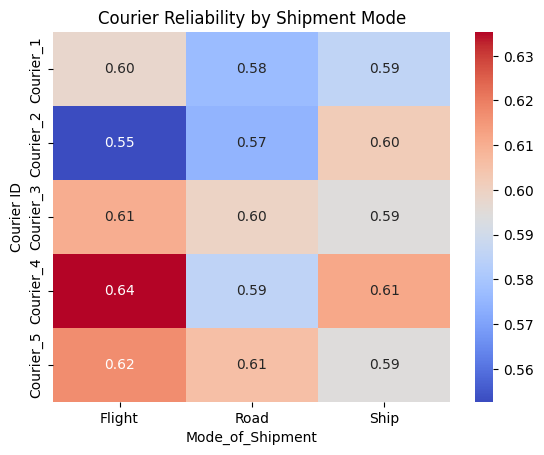

In [24]:
mode_courier = df.groupby(['Courier_ID', 'Mode_of_Shipment'])['Reached_on_time'].mean().unstack()

sns.heatmap(mode_courier, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Courier Reliability by Shipment Mode')
plt.ylabel('Courier ID')
plt.show()


- Courier_4 dominates in Ship and Flight modes.

- Courier_5 is most consistent across all three.

- Courier_2 and Courier_1 underperform, especially in Road.

- Road is generally more delay-prone, but Courier_5 and 3 seems to handle it best.

**Recomendation:**

- Flag Courier_1 as unfit for high-priority goods.
- Consider a routing rule: If Product Importance = High → assign Courier_4 or Courier_5.

based on earlier conclusions on mode of shipments and delivery timeliness

High-priority + Ship	= Prefer Courier_4, then Courier_2

High-priority + Road	= Prefer Courier_5, then Courier_3

High-priority + Flight	= Avoid Courier_1 & 2,  they underperform here


### Do weight and discount levels influence delay likelihood?

we are Binning based on distribution peaks

1. Light: 1000–2000g (early peak)

2. Medium: 2001–4000g (sparser region)

3. Heavy: 4001–6000g (second peak)

4. Very Heavy: 6001g and above

In [25]:
#checking outliers in Weight_in_gms
very_heavy_cases = df[df['Weight_in_gms'] > 6000]
print(very_heavy_cases[['ID', 'Weight_in_gms', 'Reached_on_time', 'Mode_of_Shipment']])


      ID  Weight_in_gms  Reached_on_time Mode_of_Shipment
198  199           7640                1             Ship
199  200           7846                1             Ship
205  206           7588                1             Ship
213  214           7401                1             Ship
244  245           6064                1             Ship
245  246           7684                1             Ship
251  252           6102                1             Road
257  258           6614                1             Road


since the sample size for very heavy is too Small(8), and they aren’t necessarily erroneous, we will join them with heavy

In [26]:
#binning weight in grams column
df['Weight_bin'] = pd.cut(df['Weight_in_gms'], bins=[1000, 2000, 4000, 8000], labels=['Light', 'Medium', 'Heavy'], include_lowest=True)

In [27]:
df['Weight_bin'].value_counts()

,count
Weight_bin,
Heavy,5966
Light,3245
Medium,1788


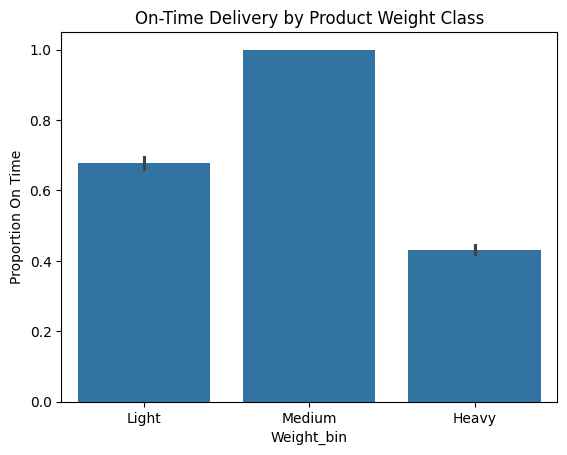

In [28]:
# Weight Impact on Delay
sns.barplot(data=df, x='Weight_bin', y='Reached_on_time')
plt.title('On-Time Delivery by Product Weight Class')
plt.ylabel('Proportion On Time')
plt.show()

In [29]:
#Cross-tab for numeric insight
pd.crosstab(df['Weight_bin'], df['Reached_on_time'], margins=True)

Reached_on_time,0,1,All
Weight_bin,,,
Light,1046,2199,3245
Medium,1,1787,1788
Heavy,3389,2577,5966
All,4436,6563,10999


- Light Weight Items have a 67.8% on-time delivery rate

it Perform better than average. These are likely easier to batch, fit standard packaging, and go through standard courier flows.

- Medium Weight Items have a 99.9% on-time. this seems anomalously high

- Heavy Items have a 56.8% delay rate, which is the worst of all 3 item weight.

it might suggest operational difficulty

#### Do some couriers perform better with heavier or lighter items?

In [30]:
# On-time delivery rate by Courier and Weight_bin
courier_weight_perf = df.groupby(['Courier_ID', 'Weight_bin'], observed=True)['Reached_on_time'].mean().unstack()
courier_weight_perf.round(3)


Weight_bin,Light,Medium,Heavy
Courier_ID,,,
Courier_1,0.667,1.000,0.422
Courier_2,0.680,1.000,0.425
Courier_3,0.681,1.000,0.442
Courier_4,0.682,1.000,0.442
Courier_5,0.678,0.997,0.429


- While no courier performs exceptionally well for heavy items, Courier_4 is the best for light items.


#### Are certain shipment modes more successful at delivering heavy vs. light items?

In [31]:
# On-time delivery rate by Mode and Weight_bin
mode_weight_perf = df.groupby(['Mode_of_Shipment', 'Weight_bin'], observed=True)['Reached_on_time'].mean().unstack()

Weight_bin,Light,Medium,Heavy
Mode_of_Shipment,,,
Flight,0.661,1.000,0.449
Road,0.649,1.000,0.435
Ship,0.688,0.999,0.427


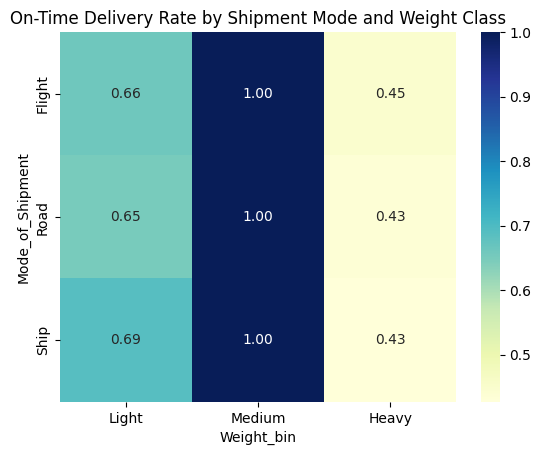

In [114]:
# visualization for On-time delivery rate by Mode and Weight_bin
sns.heatmap(mode_weight_perf, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('On-Time Delivery Rate by Shipment Mode and Weight Class')
plt.show()

Flight is slightly more reliable for heavy products than other modes — but only marginally.

Ship is best for light items but should not be the default for heavy shipments, despite assumptions.

#### Which couriers handle high-priority + heavy shipments most reliably?”

/tmp/ipython-input-32-1938166755.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot1 = df.pivot_table(


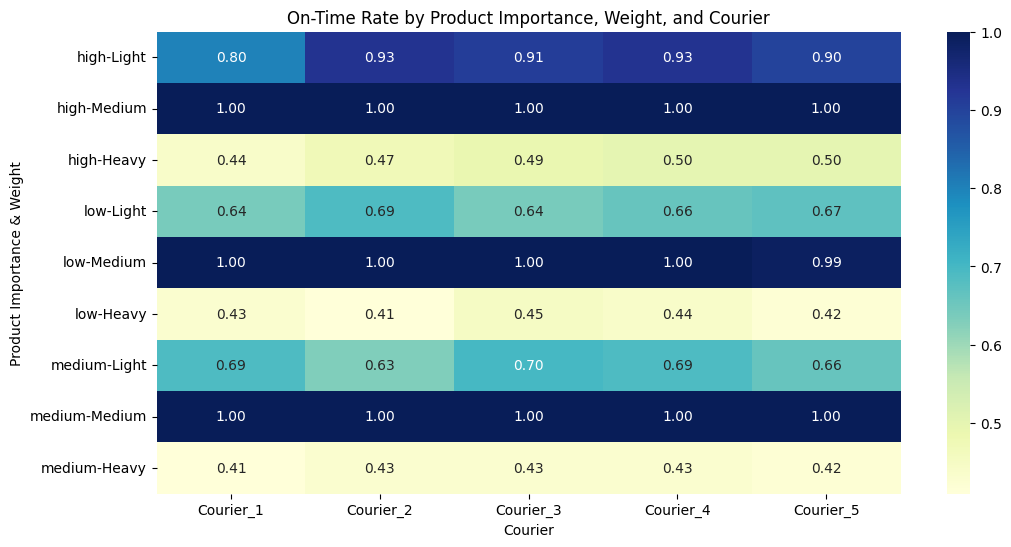

In [32]:
#Which couriers handle high-priority + heavy shipments most reliably?”
pivot1 = df.pivot_table(
    values='Reached_on_time',
    index=['Product_importance', 'Weight_bin'],
    columns='Courier_ID',
    aggfunc='mean'
).round(2)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot1, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('On-Time Rate by Product Importance, Weight, and Courier')
plt.ylabel('Product Importance & Weight')
plt.xlabel('Courier')
plt.show()

- all perform very well for high priority and light weight especially courier 2 and 5
- all couriers perform below average for all Heavy categories.

- Medium Priority: All couriers deliver 100% on-time for Medium-weight items regardless of importance — your sweet spot for fast-shipping, batching, or SLAs.

- medium/Low Priority + Heavy:  very poor performance across the board (~42–45%).


#### Discount Offered vs. Delay Rate

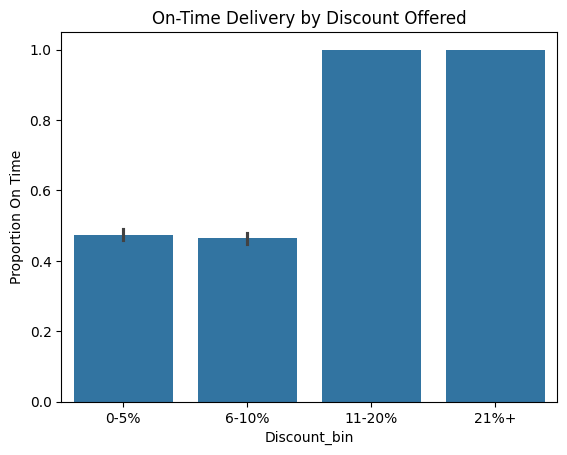

In [33]:
#Discount Impact on Delay
df['Discount_bin'] = pd.cut(df['Discount_offered'], bins=[0,5,10,20,100], labels=['0-5%', '6-10%', '11-20%', '21%+'])

sns.barplot(data=df, x='Discount_bin', y='Reached_on_time')
plt.title('On-Time Delivery by Discount Offered')
plt.ylabel('Proportion On Time')
plt.show()


In [34]:
#Cross-tab for numeric insight
pd.crosstab(df['Discount_bin'], df['Reached_on_time'], margins=True)

Reached_on_time,0,1,All
Discount_bin,,,
0-5%,2186,1971,4157
6-10%,2250,1945,4195
11-20%,0,496,496
21%+,0,2151,2151
All,4436,6563,10999


- Discounts up to 10% show high delay rates (~53%) — these are low-margin, low-priority orders.

- Discounts above 10% — shockingly perfect on-time performance (100% for 11–20% and 21%+)

#### Do high-discount orders get delayed more often depending on shipment mode?

In [35]:
# Pivot table for delay rates by discount and shipment mode
pivot2 = df.pivot_table(
    values='Reached_on_time',
    index='Discount_bin',
    columns='Mode_of_Shipment',
    aggfunc='mean'
).round(2)

pivot2

/tmp/ipython-input-35-3180271122.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot2 = df.pivot_table(


Mode_of_Shipment,Flight,Road,Ship
Discount_bin,,,
0-5%,0.47,0.47,0.48
6-10%,0.47,0.46,0.46
11-20%,1.00,1.00,1.00
21%+,1.00,1.00,1.00


high-discount items are clearly prirotized as they have a 100% on time delivery rate, likely to honor promo delivery guarantees or internal campaigns.

Across all shipment modes, delivery improves dramatically as discount increases.

### Warehouse Block Performance

In [36]:
df.groupby('Warehouse_block')['Reached_on_time'].value_counts(normalize=True).unstack().round(2)

Reached_on_time,0,1
Warehouse_block,,
A,0.41,0.59
B,0.40,0.60
C,0.40,0.60
D,0.40,0.60
F,0.40,0.60


All blocks are very similar in performance (~59–60% on-time).

Block A is slightly worse (59%) but not significantly.

No block is disproportionately delay-prone, so no block-based routing optimization is necessary at this stage.

 #### Are certain warehouse + weight + mode combos more delay-prone?

In [37]:
# Pivot table for on-time rate
pivot3 = df.pivot_table(
    values='Reached_on_time',
    index=['Warehouse_block', 'Weight_bin'],
    columns='Mode_of_Shipment',
    aggfunc='mean'
).round(2)

pivot3

/tmp/ipython-input-37-1606825653.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot3 = df.pivot_table(


Mode_of_Shipment            Flight  Road  Ship
Warehouse_block Weight_bin                    
A               Light         0.64  0.61  0.69
                Medium        1.00  1.00  1.00
                Heavy         0.42  0.43  0.42
B               Light         0.66  0.65  0.71
                Medium        1.00  1.00  1.00
                Heavy         0.45  0.43  0.44
C               Light         0.71  0.66  0.67
                Medium        1.00  1.00  1.00
                Heavy         0.47  0.41  0.43
D               Light         0.61  0.66  0.68
                Medium        1.00  1.00  1.00
                Heavy         0.46  0.43  0.43
F               Light         0.67  0.66  0.69
                Medium        1.00  1.00  1.00
                Heavy         0.45  0.45  0.43

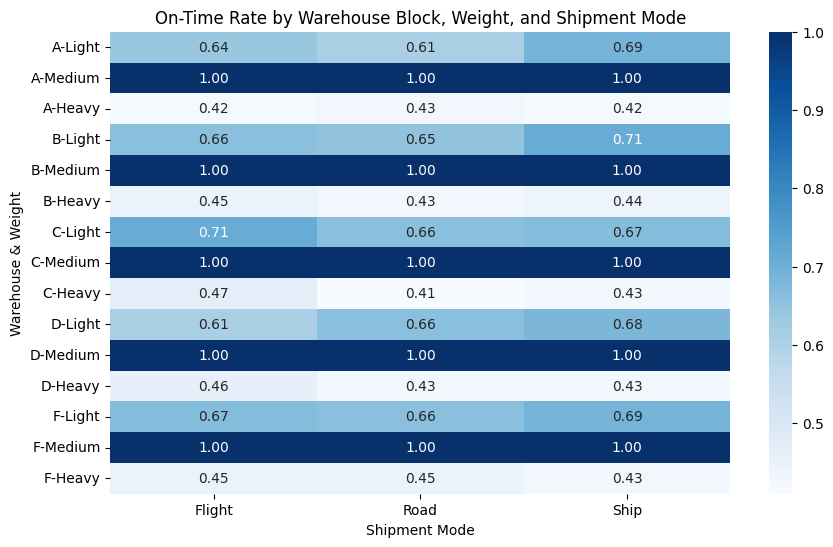

In [38]:
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot3, annot=True, cmap='Blues', fmt='.2f')
plt.title('On-Time Rate by Warehouse Block, Weight, and Shipment Mode')
plt.ylabel('Warehouse & Weight')
plt.xlabel('Shipment Mode')
plt.show()


 Heavy shipments, especially via Road or Ship, are at high delay risk

#### Do high-value products go via faster (or safer) modes?

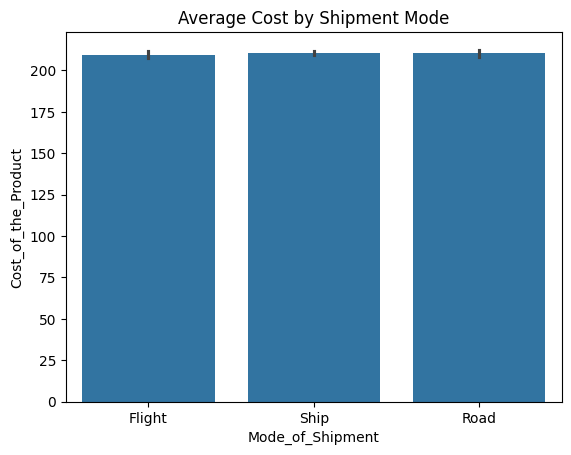

In [39]:
#High-value products vs. shipment mode (use barplot of average cost)
sns.barplot(data=df, x='Mode_of_Shipment', y='Cost_of_the_Product')
plt.title("Average Cost by Shipment Mode")
plt.show()

In [40]:
#Do high-value products go via faster (or safer) modes?, without using boxplot
df.groupby('Mode_of_Shipment')['Cost_of_the_Product'].mean().sort_values()



,Cost_of_the_Product
Mode_of_Shipment,
Flight,209.306697
Ship,210.343072
Road,210.475568


Slightly higher-cost items are going via Road

#### Are better-performing couriers assigned higher-value shipments?

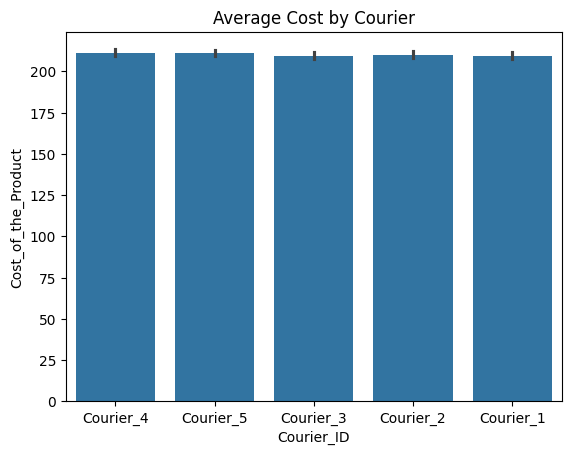

In [41]:
#High-value products vs. courier
sns.barplot(data=df, x='Courier_ID', y='Cost_of_the_Product')
plt.title("Average Cost by Courier")
plt.show()

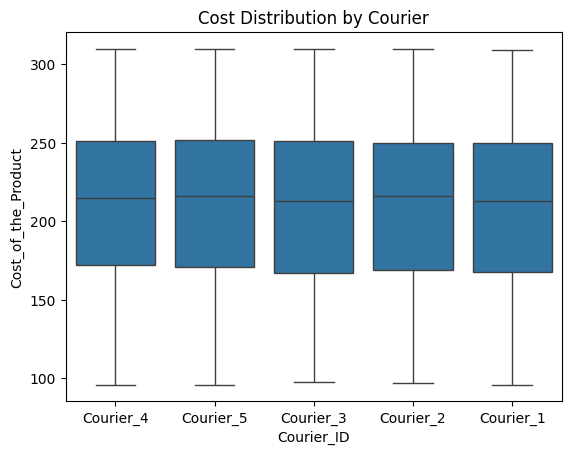

In [42]:
sns.boxplot(data=df, x='Courier_ID', y='Cost_of_the_Product')
plt.title("Cost Distribution by Courier")
plt.show()


In [43]:
#High-value products vs. courier
df.groupby('Courier_ID')['Cost_of_the_Product'].mean().sort_values()

,Cost_of_the_Product
Courier_ID,
Courier_1,209.435897
Courier_3,209.440559
Courier_2,210.018970
Courier_5,210.927614
Courier_4,211.147774


Top-performing Courier_4 handles highest-value orders.

### Customer Satisfaction:

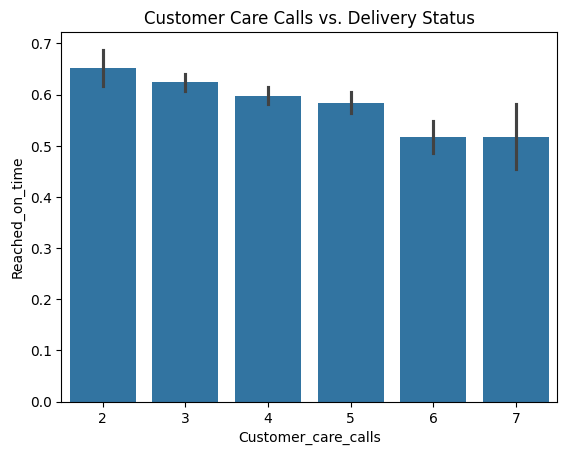

In [44]:
# Customer care calls vs. delays
sns.barplot(data=df, x='Customer_care_calls', y='Reached_on_time')
plt.title("Customer Care Calls vs. Delivery Status")
plt.show()

In [45]:
# Customer care calls vs. delays
df.groupby('Customer_care_calls')['Reached_on_time'].value_counts(normalize=True).unstack().round(2)

Reached_on_time,0,1
Customer_care_calls,,
2,0.35,0.65
3,0.37,0.63
4,0.40,0.60
5,0.42,0.58
6,0.48,0.52
7,0.48,0.52


As customer care calls increase, on-time rate drops.
This is a clear sign of customer concern and delivery risk.

Care calls are an might be an early signal of delivery disruption

In [46]:
#Rating by Delivery Status
df.groupby('Reached_on_time')['Customer_rating'].mean().round(2)

,Customer_rating
Reached_on_time,
0,2.97
1,3.01


On-time delivery yields slightly higher ratings, but the difference is small.

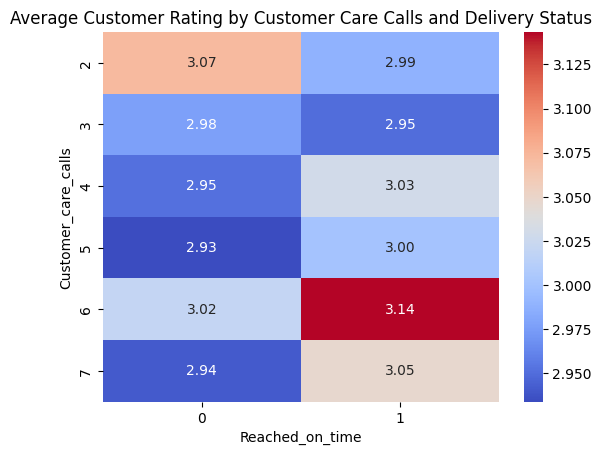

In [47]:
# Rating vs. Customer Care Calls c
pivot=df.pivot_table(index='Customer_care_calls', columns='Reached_on_time', values='Customer_rating', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Average Customer Rating by Customer Care Calls and Delivery Status")
plt.show()

ratings are most likely influenced not by only care experience, delivery and timing, but by the product

In [48]:
pd.crosstab(df['Customer_care_calls'], df['Customer_rating'])

Customer_rating,1,2,3,4,5
Customer_care_calls,,,,,
2,130,124,125,123,136
3,683,623,656,650,605
4,691,717,744,718,687
5,491,471,446,450,470
6,187,184,214,213,215
7,53,46,54,35,58


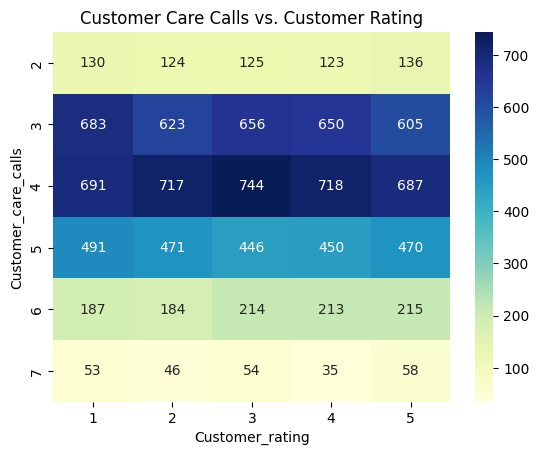

In [49]:
pivot = pd.crosstab(df['Customer_care_calls'], df['Customer_rating'])
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Customer Care Calls vs. Customer Rating")
plt.show()


In [50]:
#Courier Scorecards: Delay + Rating
courier_scores = df.groupby('Courier_ID').agg({
    'Reached_on_time': 'mean',
    'Customer_rating': 'mean'
}).rename(columns={
    'Reached_on_time': 'On_Time_Rate',
    'Customer_rating': 'Avg_Rating'
}).sort_values(by='On_Time_Rate', ascending=False)

print(courier_scores.round(2))




            On_Time_Rate  Avg_Rating
Courier_ID                          
Courier_4           0.61        2.99
Courier_5           0.60        2.95
Courier_3           0.60        3.02
Courier_2           0.59        2.96
Courier_1           0.59        3.03


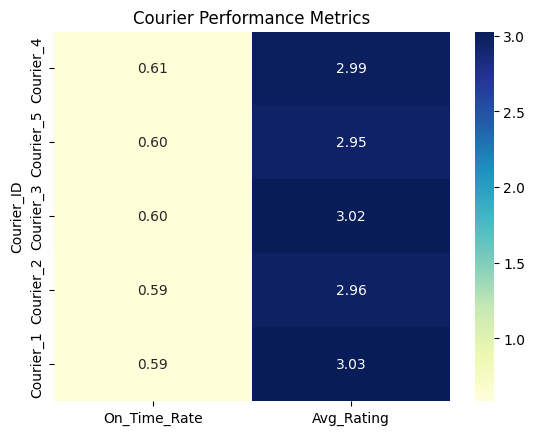

In [118]:
#visualize with heatmap
sns.heatmap(courier_scores, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Courier Performance Metrics')
plt.show()

## Order Clustering for Batching and Packaging Optimisation

Group similar orders together based on operational traits (weight, priority, discount, etc.) to optimize batching, packaging, or routing efficiency.

In [51]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [52]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_time,Courier_ID,Weight_bin,Discount_bin
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,Courier_4,Light,21%+
1,2,F,Flight,4,5,216,2,low,M,59,3088,1,Courier_5,Medium,21%+
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,Courier_3,Medium,21%+
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1,Courier_5,Light,6-10%
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,Courier_5,Medium,21%+


In [53]:
df_cluster = df[['Weight_in_gms', 'Discount_offered', 'Cost_of_the_Product', 'Product_importance', 'Mode_of_Shipment', 'Warehouse_block']]

In [54]:
df_cluster.head()

,Weight_in_gms,Discount_offered,Cost_of_the_Product,Product_importance,Mode_of_Shipment,Warehouse_block
0,1233,44,177,low,Flight,D
1,3088,59,216,low,Flight,F
2,3374,48,183,low,Flight,A
3,1177,10,176,medium,Flight,B
4,2484,46,184,medium,Flight,C


In [55]:
# Define the features
numeric_features = ['Weight_in_gms', 'Discount_offered', 'Cost_of_the_Product']
ordinal_features = ['Product_importance']
#
onehot_features = ['Mode_of_Shipment', 'Warehouse_block']  # for logistics optimization ,

In [56]:
# Create transformers
numeric_transformer = StandardScaler()
ordinal_transformer = OrdinalEncoder(categories=[['low', 'medium', 'high']])
onehot_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine them in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', onehot_transformer, onehot_features)
    ]
)


In [57]:
# Apply the transformations
X_scaled_encoded = preprocessor.fit_transform(df_cluster)

# Convert the transformed array into a DataFrame for visibility
columns_numeric = numeric_features
columns_ordinal = ordinal_features
columns_onehot = preprocessor.named_transformers_['cat'].get_feature_names_out(onehot_features).tolist()
all_columns = columns_numeric + columns_ordinal  + columns_onehot

df_encoded_scaled = pd.DataFrame(X_scaled_encoded, columns=all_columns)

df_encoded_scaled.head()

,Weight_in_gms,Discount_offered,Cost_of_the_Product,Product_importance,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F
0,-1.468240,1.889983,-0.690722,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.333893,2.815636,0.120746,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.159002,2.136824,-0.565881,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.502484,-0.208162,-0.711529,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.703244,2.013404,-0.545074,1.0,0.0,0.0,0.0,1.0,0.0,0.0


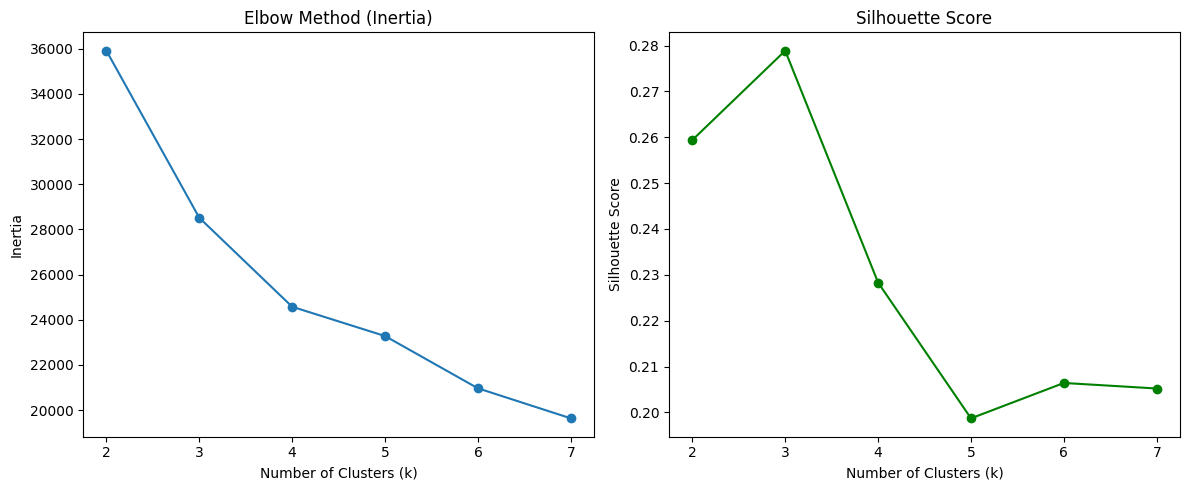

In [58]:
# Elbow Method: Inertia plot
inertias = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_encoded_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_encoded_scaled, labels))

# Plot both Elbow and Silhouette side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Elbow Method
ax[0].plot(K_range, inertias, marker='o')
ax[0].set_title("Elbow Method (Inertia)")
ax[0].set_xlabel("Number of Clusters (k)")
ax[0].set_ylabel("Inertia")

# Silhouette Score
ax[1].plot(K_range, silhouette_scores, marker='o', color='green')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("Number of Clusters (k)")
ax[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

the peak silhouete score is 3 while the "elbow" appears at k = 3

we will use k = 3 as our optimal no of clusters

In [59]:
n_clusters = 3

In [60]:
# Fit KMeans with optimal k
kmeans = KMeans(n_clusters=3, random_state=42)

 # to create a"Cluster" column in your DataFrame
cluster_labels = kmeans.fit_predict(df_encoded_scaled)

In [61]:
df_encoded_scaled['Cluster'] = cluster_labels
df_cluster['Cluster'] = cluster_labels
df_cluster['Cluster'].value_counts()

/tmp/ipython-input-61-2852181164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['Cluster'] = cluster_labels


,count
Cluster,
0,6159
1,2734
2,2106


In [62]:
df_cluster.head()

,Weight_in_gms,Discount_offered,Cost_of_the_Product,Product_importance,Mode_of_Shipment,Warehouse_block,Cluster
0,1233,44,177,low,Flight,D,2
1,3088,59,216,low,Flight,F,2
2,3374,48,183,low,Flight,A,2
3,1177,10,176,medium,Flight,B,1
4,2484,46,184,medium,Flight,C,2


In [63]:
#Explore Cluster Characteristics
df_cluster.groupby('Cluster')[['Weight_in_gms', 'Discount_offered', 'Cost_of_the_Product']].mean()



,Weight_in_gms,Discount_offered,Cost_of_the_Product
Cluster,,,
0,4939.522650,5.754181,202.451859
1,1744.954279,7.478786,243.631309
2,2268.435423,43.307217,189.442545


In [64]:
df_cluster.groupby('Cluster')['Product_importance'].value_counts(normalize=True).unstack().fillna(0)

Product_importance,high,low,medium
Cluster,,,
0,0.102614,0.447800,0.449586
1,0.031822,0.578639,0.389539
2,0.108737,0.454416,0.436847


In [65]:
df_cluster.groupby('Cluster')['Warehouse_block'].value_counts(normalize=True).unstack().fillna(0)

Warehouse_block,A,B,C,D,F
Cluster,,,,,
0,0.165449,0.166098,0.168371,0.166748,0.333333
1,0.173372,0.169715,0.162399,0.171544,0.322970
2,0.161443,0.164292,0.167142,0.160494,0.346629


In [66]:
# Assuming df_cluster has 'Cluster' column assigned from the previous steps
# And 'df_cluster' still contains the original 'Product_importance' strings.

# Analyze Cluster Characteristics
print("--- Cluster Characteristics (Means/Modes) ---")
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    cluster_data = df_cluster[df_cluster['Cluster'] == i]

    # Numerical features: Calculate mean
    # These are the truly continuous numerical features
    for col in numeric_features: # Exclude ordinal_features from this loop
        if col in cluster_data.columns:
            print(f"  {col}: {cluster_data[col].mean():.2f}")

    # Categorical and Ordinal features: Calculate mode (most frequent)
    # Now combining 'Product_importance' with one-hot features for mode calculation
    for col in onehot_features + ordinal_features:
        if col in cluster_data.columns:
            mode_val = cluster_data[col].mode()[0]
            count_mode = cluster_data[col].value_counts().max()
            total_count = len(cluster_data)
            print(f"  {col}: {mode_val} ({count_mode/total_count:.1%} of cluster)")
    print("-" * 30)

--- Cluster Characteristics (Means/Modes) ---

Cluster 0:
  Weight_in_gms: 4939.52
  Discount_offered: 5.75
  Cost_of_the_Product: 202.45
  Mode_of_Shipment: Ship (67.6% of cluster)
  Warehouse_block: F (33.3% of cluster)
  Product_importance: medium (45.0% of cluster)
------------------------------

Cluster 1:
  Weight_in_gms: 1744.95
  Discount_offered: 7.48
  Cost_of_the_Product: 243.63
  Mode_of_Shipment: Ship (67.6% of cluster)
  Warehouse_block: F (32.3% of cluster)
  Product_importance: low (57.9% of cluster)
------------------------------

Cluster 2:
  Weight_in_gms: 2268.44
  Discount_offered: 43.31
  Cost_of_the_Product: 189.44
  Mode_of_Shipment: Ship (68.8% of cluster)
  Warehouse_block: F (34.7% of cluster)
  Product_importance: low (45.4% of cluster)
------------------------------


**Cluster 0: "Heavy, Low Discount, Low-Medium Importance"**

* **Weight_in_gms:** Very High (4939.52 g). This is the defining characteristic of this cluster, indicating it contains the heaviest products.
* **Discount_offered:** Low (5.75%). Suggests these might be regular-priced, high-value items, or not part of major discount campaigns.
* **Cost_of_the_Product:** Moderate (202.45 USD).
* **Mode_of_Shipment:** Predominantly Ship (67.6%). Aligns with the overall dataset trend.
* **Warehouse_block:** Mostly F (33.3%). Also aligns with the overall dataset trend.
* **Product_importance:** Mostly Low and Medium (45.0% each).

 **Operational Implication:** This cluster represents orders with **exceptionally heavy products**. These would require specialized handling, potentially larger packaging, and specific loading procedures due to their weight. Batching these together would allow for the use of appropriate equipment and personnel, and potentially optimize truck/container space by grouping heavy items.


---


**Cluster 1: "Light, Standard Discount, Low Importance"**

* **Weight_in_gms:** Very Low (1744.95 g). This is the lightest cluster by a significant margin.
* **Discount_offered:** Standard (7.48%). Slightly higher than Cluster 0, but still relatively low.
* **Cost_of_the_Product:** Highest among the clusters (243.63 USD). Interestingly, lighter items can sometimes be more expensive (e.g., electronics).
* **Mode_of_Shipment:** Predominantly Ship (67.6%).
* **Warehouse_block:** Mostly F (32.3%).
* **Product_importance:** Predominantly Low (57.9%).

  **Operational Implication:** This cluster represents orders with **very light, low-importance products**. These orders are likely candidates for high-volume, automated, or standard packaging lines. Batching them together can optimize the use of smaller packaging materials and standard picking processes, leading to faster throughput and potentially lower shipping costs per item by consolidating small, light packages.


---



Cluster 2: "Moderate Weight, Discounted, Low Importance"

* **Weight_in_gms:** Moderate (2268.44 g). Heavier than Cluster 1, but much lighter than Cluster 0.
* **Discount_offered:** Very High (43.31%). This is the **most defining characteristic** of this cluster. These are heavily discounted items.
* **Cost_of_the_Product:** Lowest among the clusters (189.44 USD). This makes sense given the high discount.
* **Mode_of_Shipment:** Predominantly Ship (68.8%).
* **Warehouse_block:** Mostly F (34.7%).
* **Product_importance:** Predominantly Low (45.4%).

 **Operational Implication:** This cluster represents orders primarily defined by **high discounts and moderate weight/low importance**. Heavily discounted items might be part of promotional campaigns, requiring different picking sequences (e.g., from bulk bins), specific packaging inserts, or even distinct staging areas for faster turnover. Batching these together could optimize handling for promotions, ensuring all necessary materials (e.g., flyers, special packaging) are readily available.



---


Summary and Optimization Strategies:

1.  **Heavy Items (Cluster 0):** Optimize for **heavy-duty packaging**, specialized lifting equipment, and careful loading to prevent damage or exceed weight limits.
2.  **Light, Standard Items (Cluster 1):** Optimize for **speed and volume** using standard, possibly automated, small-package processes and efficient consolidation for shipping.
3.  **Heavily Discounted Items (Cluster 2):** Optimize for **promotional handling**, potentially different picking and packing workflows, and managing high turnover during sales events.

The fact that `Mode_of_Shipment` is consistently 'Ship' (around 67-68%) and `Warehouse_block` is consistently 'F' (around 32-34%) across all clusters indicates that these are **dominant overall characteristics of the orders** rather than strong differentiating factors *between* the clusters themselves. The key differentiators lie in `Weight_in_gms`, `Discount_offered`, `Cost_of_the_Product`, and `Product_importance`.

### Cluster Visualization

In [68]:
#import PCA to reduce dimensions for visualization
from sklearn.decomposition import PCA



--- Visualizing Clusters ---


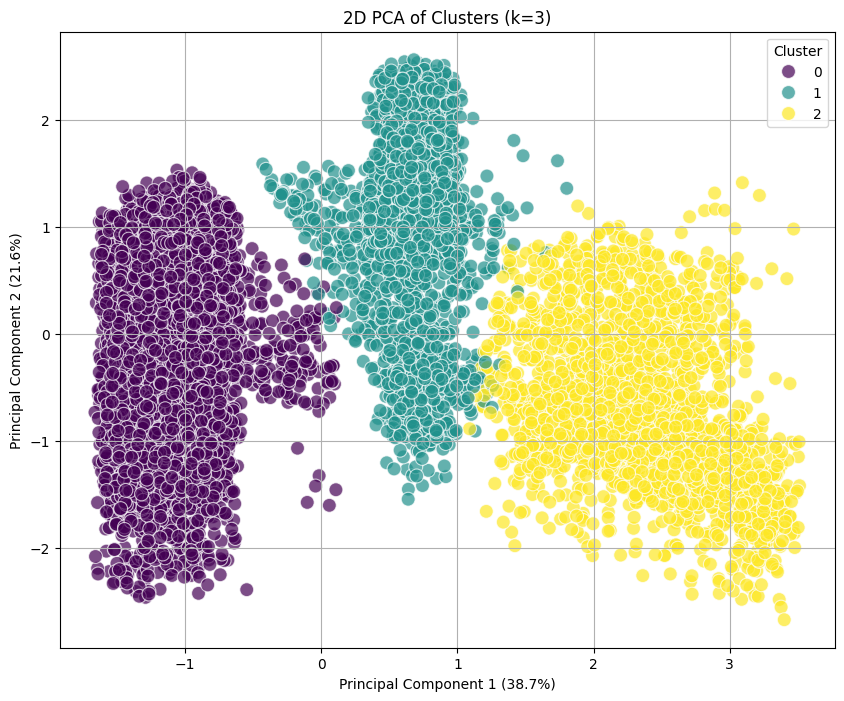

In [69]:
# Visualize Clusters with PCA ---
print("\n--- Visualizing Clusters ---")

# Reduce dimensions for visualization (2D)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_encoded_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df_cluster['Cluster'] # Add cluster labels to PCA DataFrame

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df,
                palette='viridis', s=100, alpha=0.7)
plt.title(f'2D PCA of Clusters (k={n_clusters})')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()


Text(0.5, 0, 'Cluster')

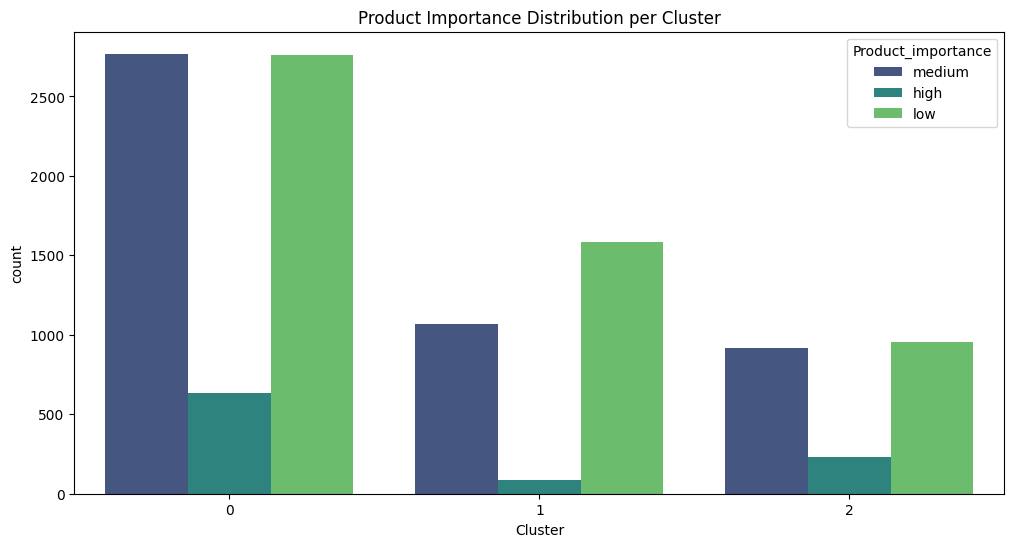

In [70]:
# Count plot for Product_importance across clusters
plt.figure(figsize=(12, 6))
sns.countplot(x='Cluster', hue='Product_importance', data=df_cluster, palette='viridis')
plt.title('Product Importance Distribution per Cluster')
plt.xlabel('Cluster')


/tmp/ipython-input-71-1501406317.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Weight_in_gms', data=df_cluster, palette='viridis')


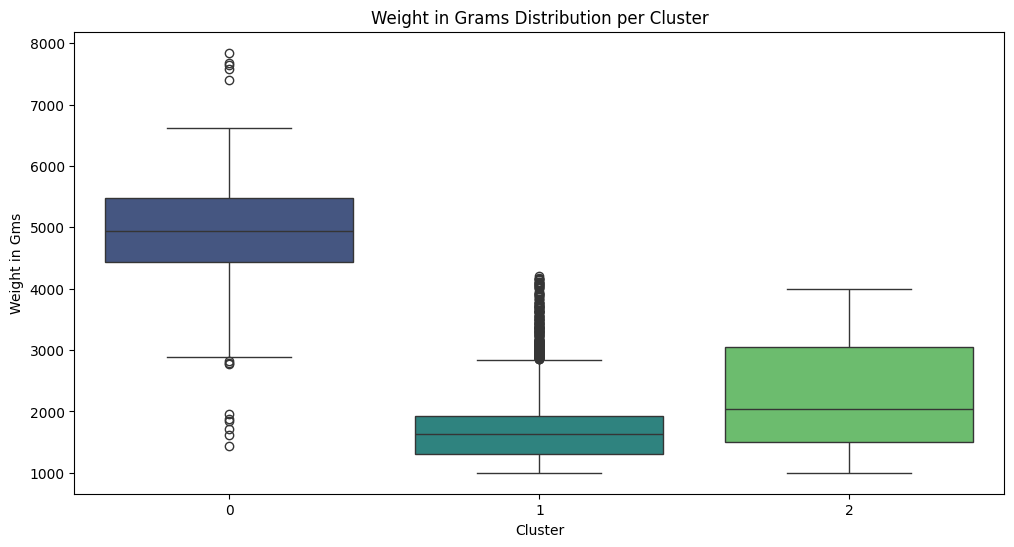

In [71]:
# Box plot for Weight_in_gms across clusters
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Weight_in_gms', data=df_cluster, palette='viridis')
plt.title('Weight in Grams Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Weight in Gms')
plt.show()

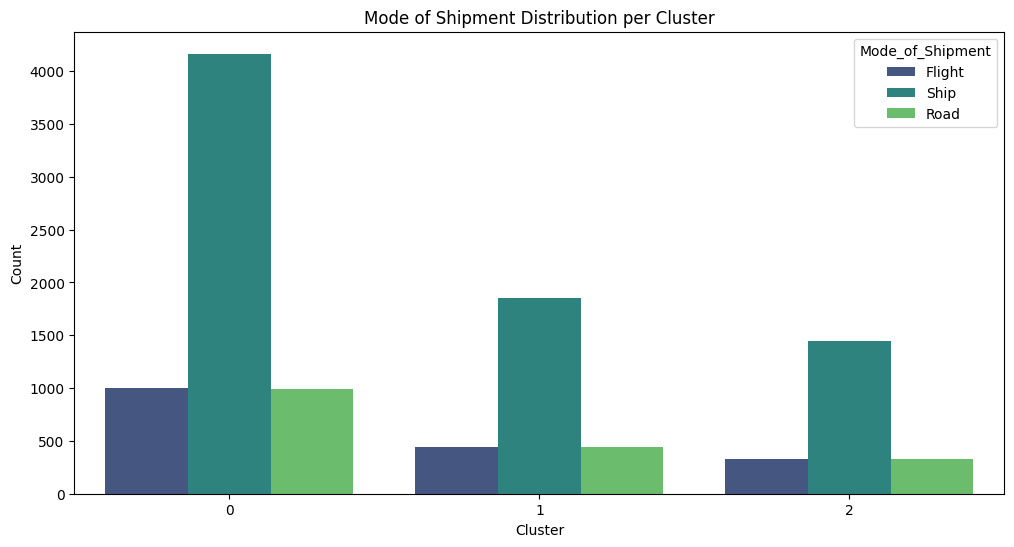

In [72]:
#Count plot for Mode_of_Shipment across clusters
plt.figure(figsize=(12, 6))
sns.countplot(x='Cluster', hue='Mode_of_Shipment', data=df_cluster, palette='viridis')
plt.title('Mode of Shipment Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

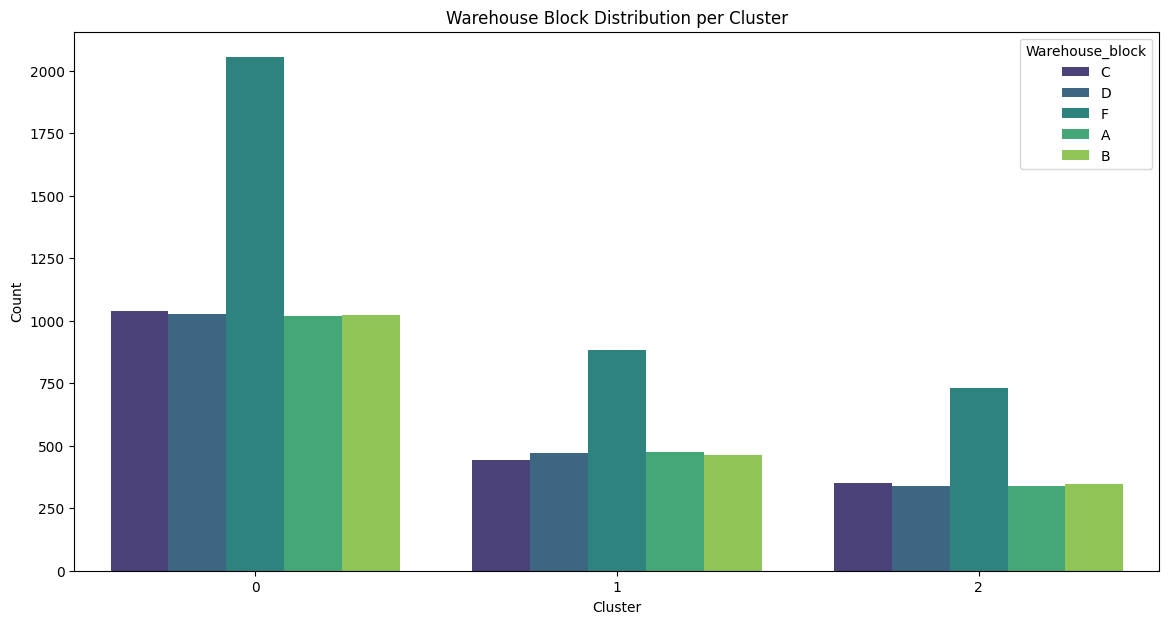

In [73]:
#  Count plot for Warehouse_block across clusters
plt.figure(figsize=(14, 7))
sns.countplot(x='Cluster', hue='Warehouse_block', data=df_cluster, palette='viridis')
plt.title('Warehouse Block Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

## MODELLING

Goal: Build a machine learning model to predict whether an order will be late This is a binary classification problem:

1 = On time

0 = Late delivery (the failure class) ← our key concern

In this case, the mistakes that hurt this business is predicting on-time when its late, it results in Major SLA breach, lost trust, churn

So we care more about:
- Capturing actual late deliveries
- Avoiding missed late predictions

In [74]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, roc_auc_score, make_scorer, roc_curve, auc, precision_recall_curve, average_precision_score


In [75]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [76]:
#importing libraries for modelling
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import joblib

import warnings
warnings.filterwarnings('ignore')

### functions

In [77]:
def model_performance_sklearn(model, predictors, target):
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred, pos_label=0)  # Focus on class '0' (Late)
    precision = precision_score(target, pred, pos_label=0)
    f1 = f1_score(target, pred, pos_label=0)

    try:
        auc_roc = roc_auc_score(target, model.predict_proba(predictors)[:, 1])
    except:
        auc_roc = "N/A"

    df_perf = pd.DataFrame({
        "Accuracy": acc,
        "Recall": recall,
        "Precision": precision,
        "F1": f1,
        "AUC-ROC": auc_roc
    }, index=[0])

    return df_perf


In [78]:
def confusion_matrix_dual(model, X_train, y_train, X_eval, y_eval, title_suffix='Validation'):
    """
    Plots side-by-side confusion matrices for train and evaluation sets.

    Parameters:
    - model: trained classifier
    - X_train, y_train: training data
    - X_eval, y_eval: validation or test data
    - title_suffix: 'Validation' or 'Test' (used in subplot titles)
    """
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_eval = model.predict(X_eval)

    # Confusion matrices
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_eval = confusion_matrix(y_eval, y_pred_eval)

    # Format labels (value + percentage)
    def format_labels(cm):
        return np.asarray([
            [f"{value}\n({value / cm.sum():.2%})" for value in row] for row in cm
        ])

    labels_train = format_labels(cm_train)
    labels_eval = format_labels(cm_eval)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm_train, annot=labels_train, fmt="", cmap="Blues", ax=axes[0], linewidths=0.5)
    axes[0].set_title("Train Set Confusion Matrix")
    axes[0].set_ylabel("True Label")
    axes[0].set_xlabel("Predicted Label")

    sns.heatmap(cm_eval, annot=labels_eval, fmt="", cmap="Purples", ax=axes[1], linewidths=0.5)
    axes[1].set_title(f"{title_suffix} Set Confusion Matrix")
    axes[1].set_ylabel("True Label")
    axes[1].set_xlabel("Predicted Label")

    plt.tight_layout()
    plt.show()


In [79]:
def class_report(model, predictors, target, binary=True):
    """
    Computes classification report for a given model and dataset.

    Parameters:
    - model: trained classifier
    - predictors: feature set (X)
    - target: true labels (y)
    - binary: True for binary classification, False for multiclass

    Returns:
    - class_report: text summary of precision, recall, f1-score
    """
    pred = model.predict(predictors)
    class_report = classification_report(target, pred, output_dict=False)
    return class_report


### PreProcessing

In [80]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_time,Courier_ID,Weight_bin,Discount_bin
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,Courier_4,Light,21%+
1,2,F,Flight,4,5,216,2,low,M,59,3088,1,Courier_5,Medium,21%+
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,Courier_3,Medium,21%+
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1,Courier_5,Light,6-10%
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,Courier_5,Medium,21%+


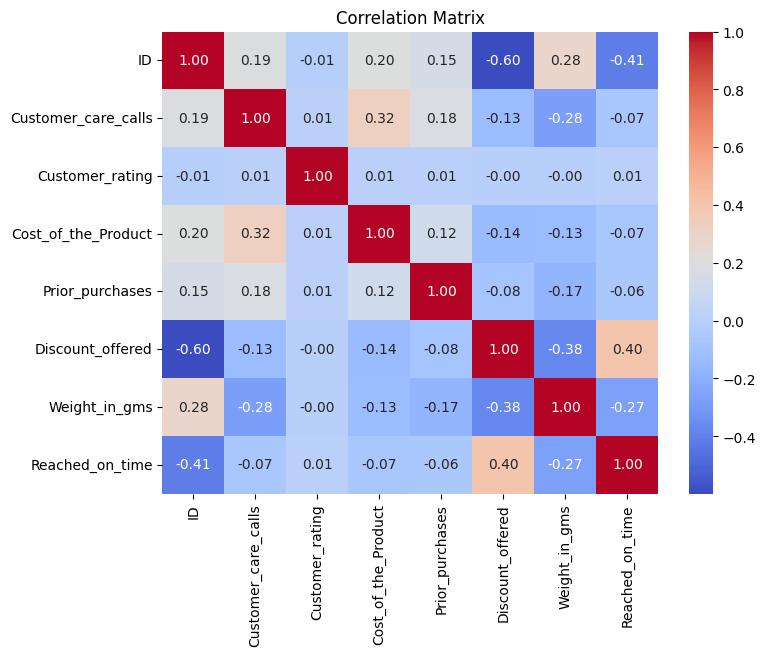

In [81]:
#correlation matrix
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


	'Discount_offered' is positively correlated with reached on time and 'Weight_in_gms is negatively correlated with reached on time

  the other variables have little to no correlation

In [82]:
#select relevant features
modelling_features = ['Warehouse_block',	'Mode_of_Shipment',	'Customer_care_calls',	'Cost_of_the_Product',	'Prior_purchases',
                      'Product_importance',	'Discount_offered',	'Weight_in_gms',	'Courier_ID', 'Reached_on_time']

In [83]:
df_modelling = df[modelling_features]

In [84]:
#drop duplicates to avoid data leakage
df_modelling.drop_duplicates(inplace=True)

In [85]:
# Define features and target
X = df_modelling.drop(columns=['Reached_on_time'])  # Drop target columns
y = df_modelling['Reached_on_time']

In [86]:
y.value_counts(normalize=True) * 100

,proportion
Reached_on_time,
1,59.669061
0,40.330939


In [87]:
# Define column types
numeric_features = ['Weight_in_gms', 'Discount_offered', 'Cost_of_the_Product', 'Customer_care_calls', 'Prior_purchases']
ordinal_features = ['Product_importance']
categorical_features = ['Mode_of_Shipment', 'Warehouse_block', 'Courier_ID']

# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('ord', OrdinalEncoder(categories=[['low', 'medium', 'high']]), ordinal_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
])

In [88]:
#First split off the test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# split remaining 85% into 70% train and 15% validation
# 15% of the original total is ~17.6% of what's left (0.15 / 0.85)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)


In [89]:
# Apply preprocessor
preprocessor.fit(X_train)

X_train_proc = preprocessor.transform(X_train)
X_val_proc = preprocessor.transform(X_val)

### models

In [90]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

param_grids = {
    'Random Forest': {'n_estimators': [100, 300], 'max_depth': [None, 10], 'min_samples_split': [2, 5]},
    'XGBoost': {'n_estimators': [100, 300], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]},
    'Extra Trees': {'n_estimators': [100, 300], 'max_depth': [None, 10]},
    'Logistic Regression': {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']},
    'CatBoost': {'iterations': [100, 300], 'depth': [4, 6, 8], 'learning_rate': [0.01, 0.1]}
}


In [91]:
combined_results = []

# Custom scoring to prioritize recall on 'late' deliveries (class 0)
recall_late = make_scorer(recall_score, pos_label=0)

for name, base_model in models.items():
    print(f"\n Tuning Model: {name}")

    grid = GridSearchCV(base_model, param_grids[name], scoring=recall_late, cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train_proc, y_train)
    best_model = grid.best_estimator_
    print(" Best Parameters:", grid.best_params_)

    # Train Set Performance
    train_perf = model_performance_sklearn(best_model, X_train_proc, y_train)
    train_perf["Model"] = name
    train_perf["Set"] = "Train"
    combined_results.append(train_perf)

    # Validation Set Performance
    val_perf = model_performance_sklearn(best_model, X_val_proc, y_val)
    val_perf["Model"] = name
    val_perf["Set"] = "Validation"
    combined_results.append(val_perf)

# Combine into a single summary table
results_df = pd.concat(combined_results, ignore_index=True)
results_df = results_df[['Model', 'Set', 'Accuracy', 'Recall', 'Precision', 'F1', 'AUC-ROC']]
results_df



 Tuning Model: Random Forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}

 Tuning Model: XGBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}

 Tuning Model: Extra Trees
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best Parameters: {'max_depth': 10, 'n_estimators': 300}

 Tuning Model: Logistic Regression
Fitting 5 folds for each of 3 candidates, totalling 15 fits
 Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

 Tuning Model: CatBoost
Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best Parameters: {'depth': 8, 'iterations': 100, 'learning_rate': 0.01}


,Model,Set,Accuracy,Recall,Precision,F1,AUC-ROC
0,Random Forest,Train,0.812021,0.983264,0.686363,0.808415,0.955164
1,Random Forest,Validation,0.653098,0.850904,0.544841,0.664315,0.713974
2,XGBoost,Train,0.695703,0.953331,0.573920,0.716497,0.769212
3,XGBoost,Validation,0.660996,0.933735,0.546737,0.689655,0.723764
4,Extra Trees,Train,0.816565,0.909881,0.713889,0.800057,0.919235
5,Extra Trees,Validation,0.653706,0.766566,0.550866,0.641058,0.718643
6,Logistic Regression,Train,0.636505,0.577728,0.546756,0.561815,0.723814
7,Logistic Regression,Validation,0.652491,0.652108,0.559432,0.602225,0.718973
8,CatBoost,Train,0.695963,0.961699,0.573402,0.718442,0.791843
9,CatBoost,Validation,0.668287,0.951807,0.551483,0.698343,0.730695


CatBoost and XGBoost both offer great recall and improved precision (less false alarms), without excessive overfitting

Logistic regression is underfitting

###XGBOOST

In [92]:
xgb_params = {
    'n_estimators': [100, 200, 300],            # More training rounds
    'max_depth': [3, 5, 6],                     # Control tree complexity
    'learning_rate': [0.01, 0.05, 0.1],         # More granular search
    'subsample': [0.8, 1.0],                    # Prevent overfitting (row sampling)
    'colsample_bytree': [0.8, 1.0]              # Prevent overfitting (feature sampling)
}
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

grid_xgb = GridSearchCV(estimator=xgb_model,param_grid=xgb_params, scoring=recall_late,cv=5, verbose=1, n_jobs=-1)

grid_xgb.fit(X_train_proc, y_train)

best_xgb_model = grid_xgb.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits


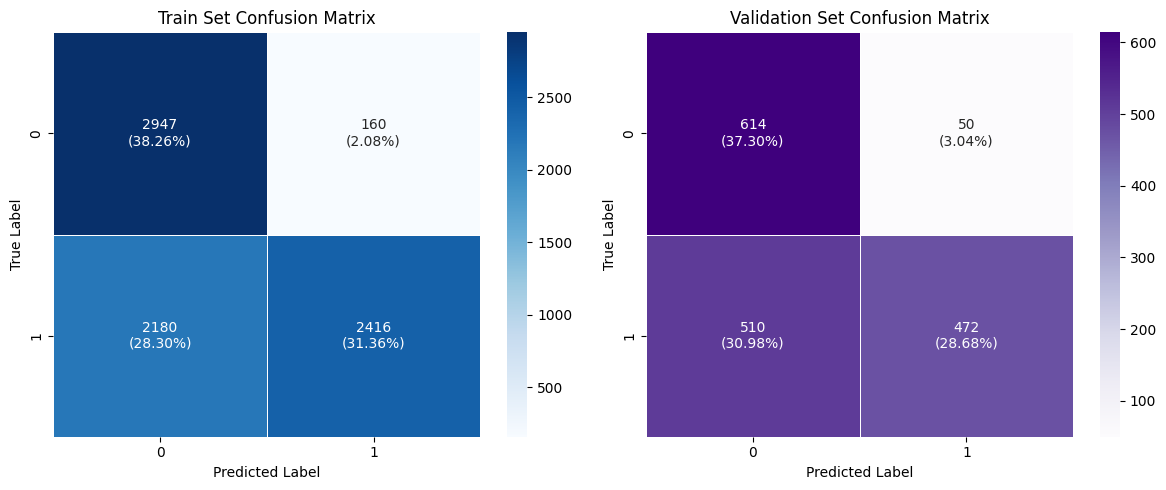

In [93]:
confusion_matrix_dual(best_xgb_model, X_train_proc, y_train, X_val_proc, y_val)


In [94]:
xgboost_train_class_report = class_report(best_xgb_model, X_train_proc, y_train)
print("The classification report for the train set is:\n", xgboost_train_class_report)

The classification report for the train set is:
               precision    recall  f1-score   support

           0       0.57      0.95      0.72      3107
           1       0.94      0.53      0.67      4596

    accuracy                           0.70      7703
   macro avg       0.76      0.74      0.69      7703
weighted avg       0.79      0.70      0.69      7703



In [95]:
xg_val_class_report = class_report(best_xgb_model, X_val_proc, y_val)
print("The classification report for the val set is:\n", xg_val_class_report)

The classification report for the val set is:
               precision    recall  f1-score   support

           0       0.55      0.92      0.69       664
           1       0.90      0.48      0.63       982

    accuracy                           0.66      1646
   macro avg       0.73      0.70      0.66      1646
weighted avg       0.76      0.66      0.65      1646



### CATBOOST

In [96]:
# Get CatBoost model
catboost_model = models['CatBoost']
catboost_params = param_grids['CatBoost']

# Tune with GridSearchCV
recall_late = make_scorer(recall_score, pos_label=0)
grid_cat = GridSearchCV(catboost_model, catboost_params, scoring=recall_late, cv=5, verbose=1, n_jobs=-1)
grid_cat.fit(X_train_proc, y_train)

# Get best tuned CatBoost model
best_catboost_model = grid_cat.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits


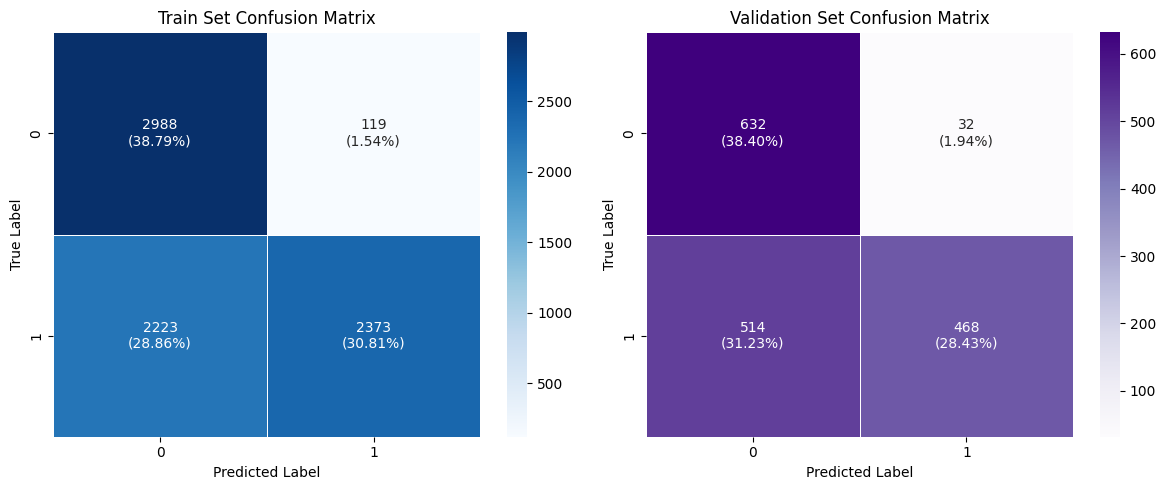

In [97]:
confusion_matrix_dual(best_catboost_model, X_train_proc, y_train, X_val_proc, y_val)


In [98]:
catboost_train_class_report = class_report(best_catboost_model, X_train_proc, y_train)
print("The classification report for the train set is:\n", catboost_train_class_report)

The classification report for the train set is:
               precision    recall  f1-score   support

           0       0.57      0.96      0.72      3107
           1       0.95      0.52      0.67      4596

    accuracy                           0.70      7703
   macro avg       0.76      0.74      0.69      7703
weighted avg       0.80      0.70      0.69      7703



In [99]:
catboost_val_class_report = class_report(best_catboost_model, X_val_proc, y_val)
print("The classification report for the val set is:\n", catboost_val_class_report)

The classification report for the val set is:
               precision    recall  f1-score   support

           0       0.55      0.95      0.70       664
           1       0.94      0.48      0.63       982

    accuracy                           0.67      1646
   macro avg       0.74      0.71      0.66      1646
weighted avg       0.78      0.67      0.66      1646



CatBoost edges out XGBoost with slightly higher recall and F1 for late deliveries.

Precision for both is modest, around 0.55, meaning roughly half of predicted delays are actual delays.

Both models generalize well: they maintain high recall from training to validation without significant drop → great sign of stability.

### Final Model Evaluation on Test Set

In [100]:
# Evaluate on test set
X_test_proc = preprocessor.transform(X_test)

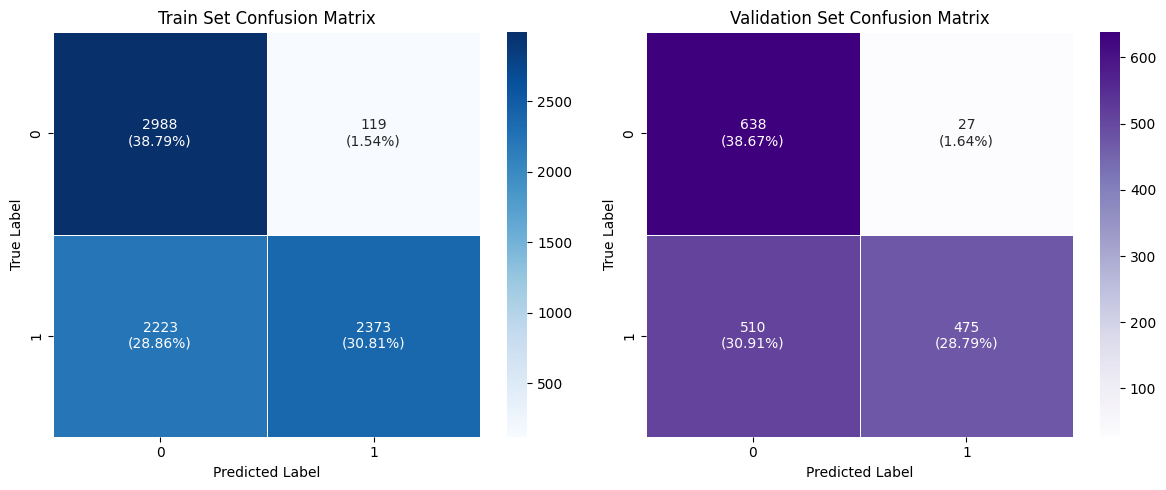

In [101]:
confusion_matrix_dual(best_catboost_model, X_train_proc, y_train, X_test_proc, y_test)

In [102]:
catboost_test_class_report = class_report(best_catboost_model, X_test_proc, y_test)
print("The classification report for the test set is:\n", catboost_val_class_report)

The classification report for the test set is:
               precision    recall  f1-score   support

           0       0.55      0.95      0.70       664
           1       0.94      0.48      0.63       982

    accuracy                           0.67      1646
   macro avg       0.74      0.71      0.66      1646
weighted avg       0.78      0.67      0.66      1646



CatBoost caught 95% of actual late deliveries on unseen data, huge win for SLA protection.

It sacrifices some precision (false alarms), but that trade-off is worthwhile if late deliveries are costly.

Class 1 (on-time) performance takes a hit in recall, which is expected, since we are optimizing for class 0.

Even macro and weighted averages show healthy model balance. And since test recall is in line with validation (95% vs 95%), the model is generalizing well and is not overfitting.

### Feature Importance (CatBoost)

In [103]:
# Get feature names from transformed data
transformed_feature_names = preprocessor.get_feature_names_out()

# top features
importances = best_catboost_model.feature_importances_
feature_df = pd.DataFrame({'Feature': transformed_feature_names,'Importance': importances}).sort_values(by='Importance', ascending=False)
feature_df

,Feature,Importance
1,num__Discount_offered,53.219545
0,num__Weight_in_gms,22.775849
2,num__Cost_of_the_Product,6.843359
4,num__Prior_purchases,6.811640
3,num__Customer_care_calls,2.662668
5,ord__Product_importance,1.805098
6,cat__Mode_of_Shipment_Road,1.072075
7,cat__Mode_of_Shipment_Ship,0.872428
10,cat__Warehouse_block_D,0.853781
13,cat__Courier_ID_Courier_3,0.697413


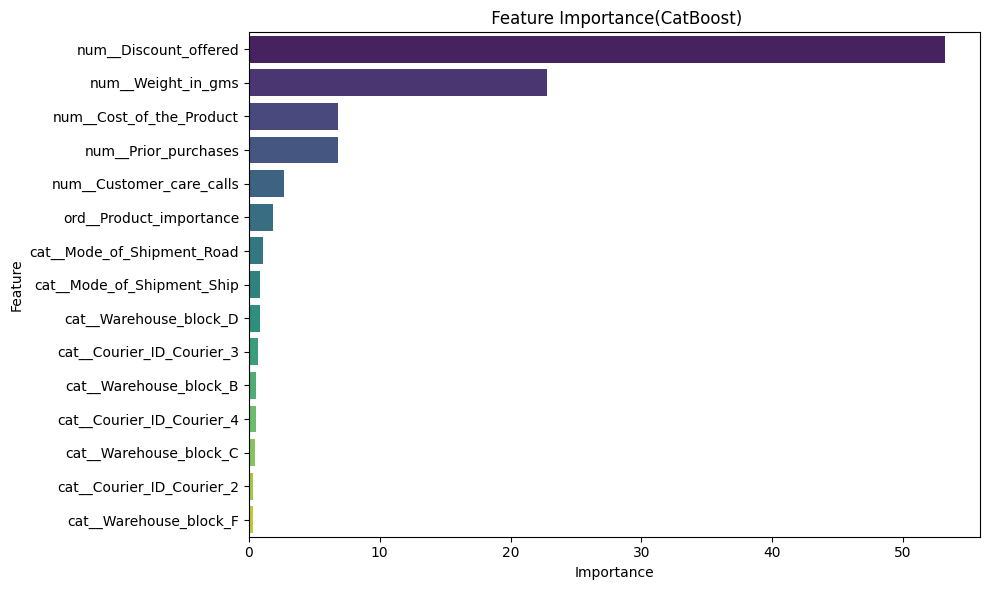

In [104]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df.head(15), palette='viridis')
plt.title(" Feature Importance(CatBoost)")
plt.tight_layout()
plt.show()


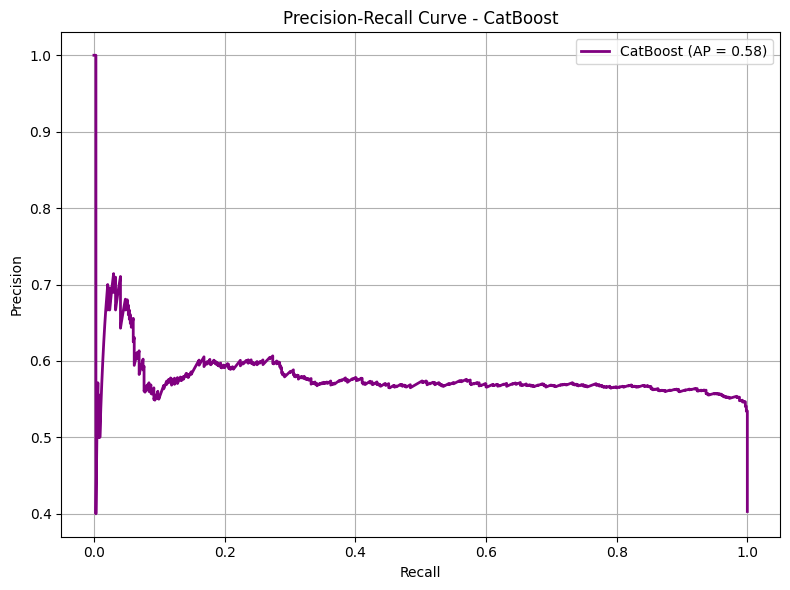

In [105]:
from sklearn.metrics import precision_recall_curve, average_precision_score


# Generate probabilities for class 0 (Late)
y_probs = best_catboost_model.predict_proba(X_test_proc)[:, 0]  # Class 0 probs
precision, recall, thresholds = precision_recall_curve(y_test, y_probs, pos_label=0)
avg_precision = average_precision_score(y_test, y_probs, pos_label=0)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'CatBoost (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - CatBoost')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


After the early drop, precision plateaus and holds near 0.6 over a wide recall range—suggesting consistent performance across thresholds.